In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import importlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sys
sys.path.append('../')

from modules import aperturephotometry as aph
from modules import tesscut_interface as tci


importlib.reload(aph)
importlib.reload(tci)

# %matplotlib qt
# %matplotlib inline

<module 'modules.tesscut_interface' from '/home/lukas/github/MasterThesisComputerScience/TPF_video_prediction/demos/../modules/tesscut_interface.py'>

In [2]:
#define targets

# tesstr_path = f'../data/tess_transients.parquet'
# df_tesstr = pl.read_parquet(tesstr_path).filter(pl.col('#sector')==60)[:]
# display(df_tesstr)
# print(repr(df_tesstr.select(pl.col('ra','dec','name')).to_dicts()))

#control
save_tpfs = f'./data/'

#define targets
transients = [
    dict(coords=SkyCoord(327.16008333,-43.38001944, unit=u.deg), name='2018evo', sectors=[1],  period=1e8),
    # dict(coords=SkyCoord(315.03341667,-40.35859444, unit=u.deg), name='2018exc', sectors=[1],  period=1e8),
    # dict(coords=SkyCoord(313.47458333,-38.01559444, unit=u.deg), name='2018fgb', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(342.82569167,-38.87439722, unit=u.deg), name='2018exg', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(332.648,     -27.25016111, unit=u.deg), name='2018emt', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(7258.67275,  66.856131,    unit=u.deg), name='2023ael', sectors=None, period=1e8), #extract all available sectors
]
rrlyr = [
    dict(coords=SkyCoord('19 25 27.9129605304 +42 47 03.693258204', frame='icrs', unit=(u.hourangle, u.deg)), name='RRLyr', sectors=[14,40],   period=0.5667732268824381),
    dict(coords=SkyCoord('14 16 36.5814789480 +42 21 35.712985824', frame='icrs', unit=(u.hourangle, u.deg)), name='TVBoo', sectors=[1,16,23], period=0.3125589785657776),
]

df_targets = pl.from_dicts(transients+rrlyr)
display(df_targets)


coords,name,sectors,period
object,str,list[i64],f64
"<SkyCoord (ICRS): (ra, dec) in deg (327.16008333, -43.38001944)>","""2018evo""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (342.82569167, -38.87439722)>","""2018exg""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (332.648, -27.25016111)>","""2018emt""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (58.67275, 66.856131)>","""2023ael""",null,1e8
"<SkyCoord (ICRS): (ra, dec) in deg (291.366304, 42.78435924)>","""RRLyr""","[14, 40]",0.566773
"<SkyCoord (ICRS): (ra, dec) in deg (214.15242283, 42.35992027)>","""TVBoo""","[1, 16, 23]",0.312559


In [3]:
#load data
TCI = tci.TESScut_Interface(
    n_jobs=5,
    redownload=True,
    sleep=.5,
    verbose=1,
)

#download
hdulists = TCI.download(
    coordinates=df_targets['coords'],
    sectors=df_targets['sectors'],
    targ_ids=df_targets['name'],
    combine_sectors=True,       #combine all downloaded sectors into one array
    ffi_header_keys=['TELESCOP'],
    prim_header_keys=['TELESCOP', 'INSTRUME'],
    col_keys=['SECTOR','EXPOSURE'],
    n_jobs=None,
    savedir=save_tpfs,
    # savedir=None,             #don't save
    filenames=None,             #autogenerate
    verbose=None,
    parallel_kwargs=dict(backend='threading'),
    get_cutouts_kwargs=dict(size=[15,12], product='SPOC'),   #size=(ny,nx)
)

In [4]:
#in case you already have the files downloaded
from astropy.io import fits
hdulists = [fits.open(f'./{save_tpfs}{name}_tpfs.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7464594801c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d623e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62710>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x746402d60460>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62b00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62fe0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x746402d609d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d63280>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d63940>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x746402d61e70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62bc0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x746402d62020>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d62bf0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x746402d60a90>], [<as

In [5]:
tpfs = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
tpfs_e = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
times = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]


In [6]:
#custom function to calculate variants of the fluxes
def sectornorm(
    X:np.ndarray, X_e:np.ndarray,
    sector:np.ndarray,
    eps:float=1e-9,
    ) -> np.ndarray[np.ndarray,np.ndarray]:
    """
        - function to compute a normalized version of X
        - computes
            - normalized X w.r.t. global median (and errors)
            - normalized X w.r.t. sectorwise median (and errors)

        Parameters
        ----------
            - `X`
                - `np.ndarray`
                - 1d
                - series of fluxes to be normalized
            - `X_e`
                - `np.ndarray`
                - same shape as `X`
                - errors corresponding to `X`
            - `sector`
                - `np.ndarray`
                - 1d
                - contains for each frame the sector it was observed in
            - `eps`
                - `float`, optional
                - constant for numerical stability upon division
                - relevant if median of LC is exactly `0.0`
        
        Raises
        ------

        Returns
        -------
            - `X_norm`
                - `np.ndarray`
                - contains normalized versions of `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized
            - `X_norm_e`
                - `np.ndarray`
                - contains errors corresponding to `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized

        Dependencies
        ------------
            - `numpy`
        
        Comments
        --------
    """
    #initialize
    X_norm = np.empty((X.shape[0],2))
    X_norm_e = np.zeros_like(X_norm)*np.nan
    
    #compute fluxes and errors
    X_norm[:,0] = X/np.nanmedian(X)
    X_norm_e[:,0] = X_e/np.nanmedian(X)
    for s in np.unique(sector):
        sbool = (sector==s)
        X_norm[sbool,1] = X[sbool] / (np.median(X[sbool]+eps))
        X_norm_e[sbool,1] = X_e[sbool] / (np.median(X[sbool])+eps)
    
    return X_norm, X_norm_e


1/6
2/6


/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


3/6
4/6
5/6
6/6


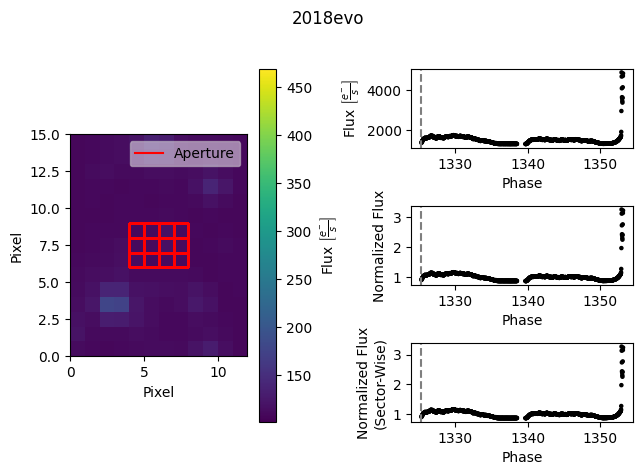

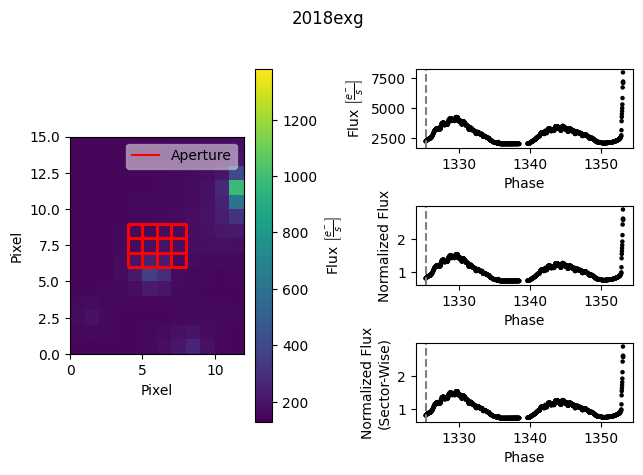

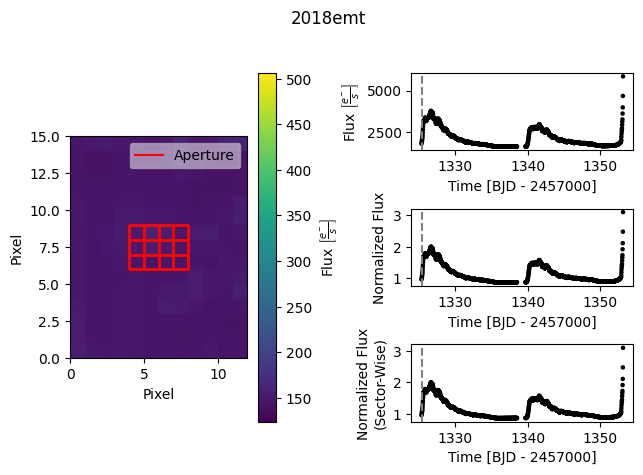

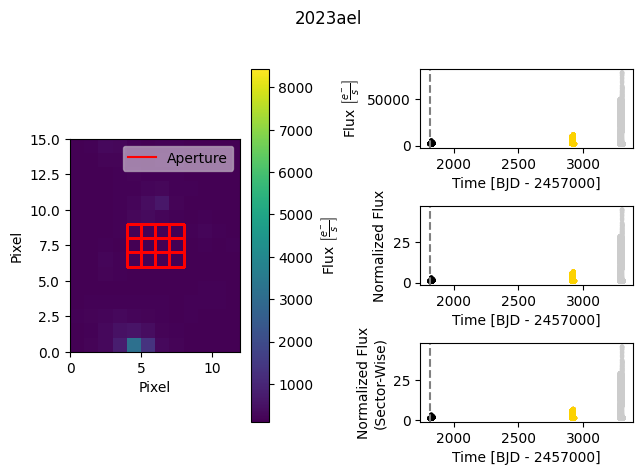

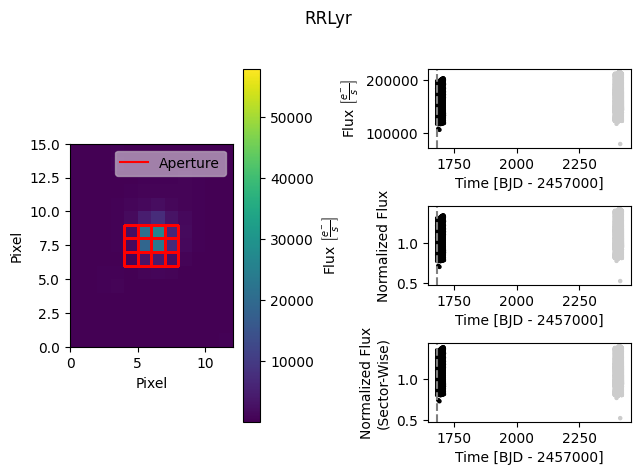

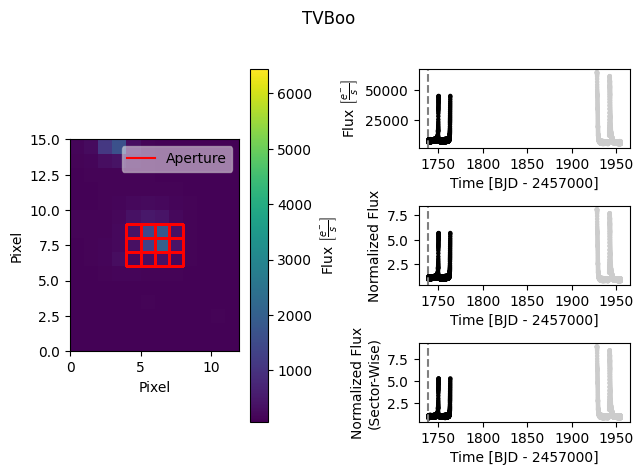

In [7]:
#instantiate
AP = aph.AperturePhotometry(
    verbose=2,
    n_jobs=1,
)

AP.fit(
    X=tpfs, y=None, X_e=tpfs_e,
    apertures=2,
    fluxvars=sectornorm,
    # fluxvars=lambda x, x_e, **kwargs:(None, None),
    n_jobs=None,
    verbose=None,
    fluxvars_kwargs=[dict(sector=secs) for secs in sectors],
)

X_fluxes, X_fluxes_e, apertures = AP.transform(X=tpfs)

# X_fluxes, X_fluxes_e, apertures = AP.fit_transform(
#     X=tpfs, y=None, X_e=tpfs_e,
#     verbose=None,
#     fit_kwargs=dict(
#         fluxvars=sectornorm,
#         n_jobs=None,
#         fluxvars_kwargs=[dict(sector=secs) for secs in sectors],
#     )
# )

#initialization
for idx in range(0,len(X_fluxes)):
    print(f'{idx+1}/{len(X_fluxes)}')

    if idx < 2:
        x_vals = times[idx]%df_targets['period'][idx]    #periods
        sort_idxs = np.argsort(x_vals)
        Xf      = X_fluxes[idx][sort_idxs]
        Xf_e    = X_fluxes_e[idx][sort_idxs]
        x_vals  = x_vals[       sort_idxs]
        secs    = sectors[idx][ sort_idxs]
        tpfsi   = tpfs[idx][    sort_idxs]
        xlabs   = r'Phase'
    else:
        Xf      = X_fluxes[idx]
        Xf_e    = X_fluxes_e[idx]
        x_vals  = times[idx]    #times
        secs    = sectors[idx]  #sectors
        tpfsi = tpfs[idx]
        xlabs = r'Time [BJD - 2457000]'

    fig = plt.figure()
    fig.suptitle((
        f'{hdulists[idx][0].header["TARGNAME"]}\n'
    ))

    fig, axs, anim = AP.plot_result(
        X=Xf, y=None, X_e=Xf_e,
        x_vals=x_vals, X_in=tpfsi, aperture=apertures[idx],
        fig=fig,
        animate=True,
        pcolormesh_kwargs=None,
        sctr_kwargs=dict(c=secs, cmap='nipy_spectral', s=5, alpha=1),
        func_animation_kwargs=dict(repeat=False, frames=range(0,Xf.shape[0],100)),
    )
    axs[2].set_xlabel(xlabs)
    axs[3].set_xlabel(xlabs)
    axs[4].set_xlabel(xlabs)
    axs[1].set_ylabel(r'Flux $\left[\frac{e^-}{s}\right]$') #cbar
    axs[2].set_ylabel(r'Flux $\left[\frac{e^-}{s}\right]$')
    axs[3].set_ylabel(r'Normalized Flux')
    axs[4].set_ylabel('Normalized Flux\n(Sector-Wise)')

    # anim.save(
    #     f'../temp_{targnames[idx]}.gif',
    #     writer='pillow',
    #     # savefig_kwargs=dict(bbox_inches='tight')
    # )

